In [1]:
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import os
from PIL import Image

import random
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(7)

In [3]:
class CroppedDataset(Dataset): # assume that all shapes are the same
    def __init__(self, folder_path, patch_size=(32, 32)):
        super().__init__()
        self.folder_path = folder_path
        self.image_pathes = os.listdir(folder_path)
        self.patch_size = patch_size
        
        img = plt.imread(os.path.join(self.folder_path, self.image_pathes[0]))
        img = img[:-38] ## cut the bottom line
        self.patches_i = int(img.shape[0] / self.patch_size[0])
        self.patches_j = int(img.shape[1] / self.patch_size[1])
        self.n_patches = self.patches_i * self.patches_j
        
        self.data = []
        for path in self.image_pathes:
            img = plt.imread(os.path.join(self.folder_path, path))
            self.data.append(img)

    def __len__(self):
        return len(self.image_pathes) * self.n_patches

    def __getitem__(self, index):
        img_index = index // self.n_patches
        #img = plt.imread(os.path.join(self.folder_path, self.image_pathes[img_index]))
        img = self.data[img_index]
        if len(img.shape) > 2:
            img = img[:, :, 0]
        img = img[:-38] ## cut the bottom line
        img = img / 255
        
        patch_index = index % self.n_patches ## select patch
        patch_i = patch_index // self.patches_j
        patch_j = patch_index % self.patches_j
        img = img[patch_i * self.patch_size[0]:(patch_i + 1) * self.patch_size[0],
                 patch_j * self.patch_size[1]:(patch_j + 1) * self.patch_size[1]]
        img = img.round() ## binarization
        return img

In [4]:
folder_path = '/kaggle/input/vkr-data/data2/micrographs/'

dataset = CroppedDataset(folder_path)

In [5]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],
                                                           generator=torch.Generator().manual_seed(7))

In [6]:
import torchvision.transforms as T

train_dataloader = DataLoader(train_dataset, batch_size = 512, shuffle = True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size = 512, shuffle = False, num_workers=2)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU()
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, self.latent_dim)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU()
        )
        
        
    def forward(self, x):      
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear1(x)
        
        x = self.linear2(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        
        return torch.sigmoid(x).round()
        
        

In [8]:
from IPython.display import display, clear_output
from ipywidgets import Output
from tqdm.auto import trange
from typing import Type, Union
import matplotlib.pyplot as plt


def train_epoch(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    verbose_num_iters: int = 32,
    device: torch.device = "cuda", 
    conditional: bool = False
):
    model.to(device)
    model.train()
    epoch_loss_trace = []
    
    display()
    out = Output()
    display(out)
    
    for i, x in tqdm(enumerate(train_dataloader), leave=False, total=len(train_dataloader)):
        x = x.unsqueeze(1).float()
        x = x.to(device)
        reconstructed_x = model(x)
        loss = criterion(x, reconstructed_x)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss_trace.append(loss.item())

        if (i + 1) % verbose_num_iters == 0:
            with out:
                clear_output(wait=True)

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("Current epoch loss", fontsize=22)
                plt.xlabel("Iteration", fontsize=16)
                plt.ylabel("Reconstruction loss", fontsize=16)
                plt.grid()
                plt.plot(epoch_loss_trace)

                for j in range(3):
                    plt.subplot(2, 6, 4 + j)
                    plt.axis("off")
                    plt.imshow(x[j].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

                    plt.subplot(2, 6, 10 + j)
                    plt.axis("off")
                    plt.imshow(reconstructed_x[j].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

                plt.show()
    
    out.clear_output()
    
    return epoch_loss_trace


def train_model(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int = 5, 
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
    conditional: bool = False
):
    loss_trace = []
    for epoch in tqdm(range(num_epochs), desc="Epoch: ", leave=True):        
        epoch_loss_trace = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            verbose_num_iters=verbose_num_iters,
            device=device,
            conditional=conditional
        )
        
        loss_trace += epoch_loss_trace
        
    plt.figure(figsize=(10, 5))
    plt.title("Total training loss", fontsize=22)
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Reconstruction loss", fontsize=16)
    plt.grid()
    plt.plot(loss_trace)
    plt.show()
    
    model.eval()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

Output()

  0%|          | 0/451 [00:00<?, ?it/s]

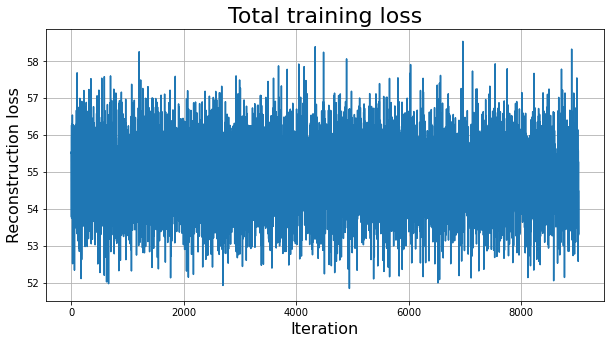

In [9]:
model = AutoEncoder(latent_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.BCELoss()
train_model(model, train_dataloader, optimizer, device=device, num_epochs=20)

In [32]:
def predict():
    original = []
    reconstructed = []
    for i, x in tqdm(enumerate(val_dataloader), leave=False, total=len(val_dataloader)):
        x = x.unsqueeze(1).float()
        x = x.to(device)
        reconstructed_x = model(x)
        original.append(x)
        reconstructed.append(reconstructed_x)
    return original, reconstructed

In [33]:
original, reconstructed = predict()

  0%|          | 0/113 [00:00<?, ?it/s]

In [52]:
from sklearn.metrics import mean_squared_error, accuracy_score

print('Accuracy:', accuracy_score(torch.cat(original).cpu().detach().numpy().astype(int).flatten(),
               torch.cat(reconstructed).cpu().detach().numpy().astype(int).flatten()))

print('MSE:', mean_squared_error(torch.cat(original).cpu().detach().numpy().astype(int).flatten(),
               torch.cat(reconstructed).cpu().detach().numpy().astype(int).flatten()))

Accuracy: 0.5433595613022459
MSE: 0.45664043869775406
